# ***Presentación***

## **Tecnicatura Universitaria en Inteligencia Artificial**

### Trabajo Práctico - Minería de Datos

#### Arboles de descición y aprendizaje supervizado

---

**Equipo**:
- Revello Simon
- Giampaoli Fabio

**Fecha**: 10/11/2023

---

## ***Objetivo***



El objetivo de este trabajo practico es integrar los conocimientos adquiridos en las unidades 4 (Arboles de desición) y 5 (Clasificación con Aprendizaje Automatico)
en dos problemas reales asociados uno al comportamiento financiero de 1000 empresas y otro a
un juego de cartas.

# ***Entorno***

En este bloque se importaran los modulos y conjuntos de datos inciales que seran de utilidad para el desarrollo de funcionalidades especificas de los problemas.

## Librerias

In [51]:
# procesamiento
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import widgets, interact
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree

# modelos
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTENC

## Datasets

Debe asegurarse de que la ruta a los archivos sea la correcta acorde a su entorno. En este caso cargamos ambos datasets al mismo tiempo en el entorno.

In [2]:
cartas = pd.read_csv('PokemonDB.csv')
companies = pd.read_csv('1000_Companies.csv')

# ***Ejercicios***

## **Primer ejercicio**

---

Descargar el conjunto de datos, 1000_Companies.csv1, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.) y elegir un método de estandarización

---

### Información básica

Se pretende navegar atraves de la composición básica de este dataset. Damos a conocer su tamaño, tipos de datos, muestras de filas, metricas generales, y conocer la presencia de valores faltantes, y la cantidad de valores unicos de cada variable de forma gráfica.

In [3]:
companies.shape

(1000, 5)

In [4]:
companies.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [6]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [7]:
def graficar_datos_faltantes(df):
    df = df.copy()
    total = df.shape[0]
    nulos = df.isnull().sum() # obtiene todos los nulos

    df_grafico = pd.DataFrame({'total': total, 'nulos': nulos}) # genera un dataframe de forma temporal

    plt.figure(figsize=(10, 6))
    sns.barplot(y=df_grafico.index, x=df_grafico['total'], color='violet', alpha=0.5) # bar que muestra todos los registros
    sns.barplot(y=df_grafico.index, x=df_grafico['nulos'], color='blue', alpha=0.5) # bar que muestra solo los nulos

    plt.xlabel('Cantidad de registros', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Cantidad de datos faltantes por variable', fontsize=16)

    plt.show()

def graficar_elementos_unicos(df):
    n_unicos = df.nunique() # obtiene el numero de valores unicos de cada variable

    plt.figure(figsize=(10, 6))
    sns.barplot(x=n_unicos.index, y=n_unicos.values, alpha=0.8) # grafico en barplot

    plt.ylabel('Cantidad de elementos únicos', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.title('Cantidad de elementos únicos por variable', fontsize=16)
    plt.xticks(rotation='vertical')

    plt.show()

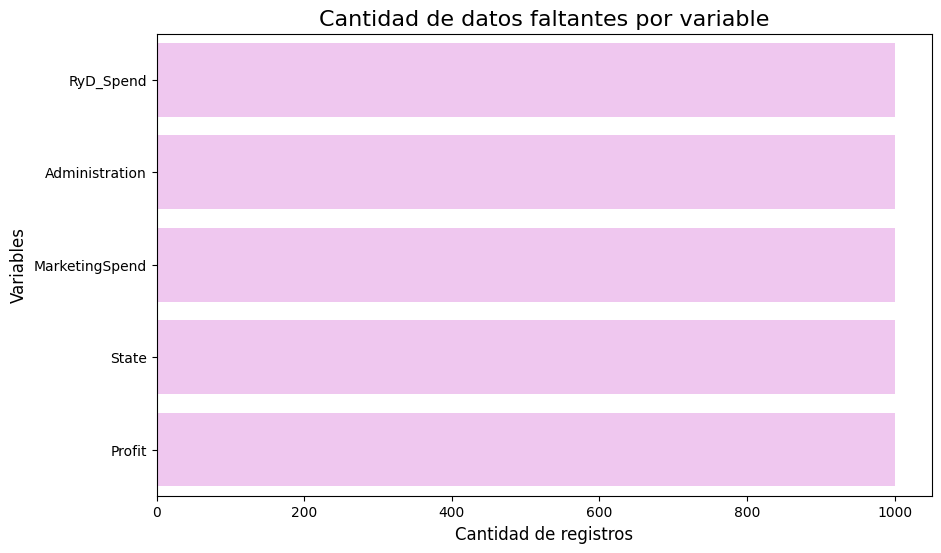

In [8]:
graficar_datos_faltantes(companies)

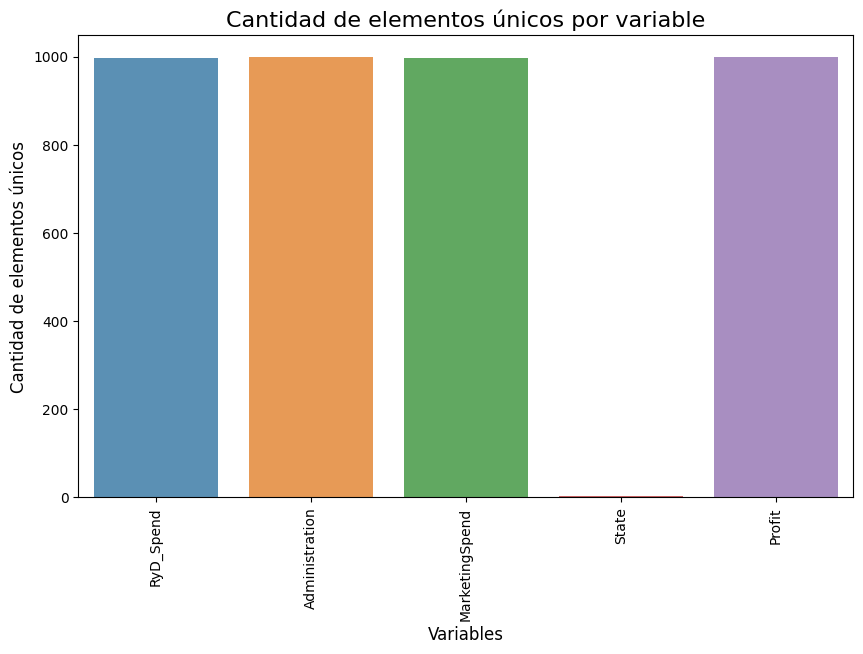

In [9]:
graficar_elementos_unicos(companies)

Podemos visualizar que el dataframe no tiene valores nulos. Y ademas las 4 variables continuas tiene casi tantos valores distintos como registros del dataframe. A excepción de State, que solo unos pocos estados sobre los que se registran datos.

### Distribuciones por clase

La siguiente celda de codigo tiene la intención de mostrar la distribución de una variable con respecto al estado.

Se genera un menu de selección de la variable para visualizar, y un filtro por el estado. Se genera un grafico con tres figuras: Una distribución de puntos en una dimensión para entender donde se concentran los datos y clases; diagramas de cajas; diagramas de densidad.

In [10]:
def create_plots(df, explanatory_var, class_var, class_value):
    if class_value != 'Todas': # aniade la opcion de ver todas los estados a la vez
        df = df[df[class_var] == class_value]

    fig, axs = plt.subplots(3, 1, figsize=(6,8))

    # scatter unidimensional
    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=class_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + class_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    # caja de metricas de distribucion
    sns.boxplot(y=class_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    # densidad de datos
    sns.kdeplot(data=df, x=explanatory_var, hue=class_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

# menu de seleccion de variable
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in companies.columns if col not in ['State']],
    description='Explicativa:',
)

# menu de seleccion de estado
class_value_widget = widgets.Dropdown(
    options=['Todas'] + list(companies['State'].unique()),
    description='State:',
)

# genera interacion
interact(create_plots, df=widgets.fixed(companies), explanatory_var=explanatory_var_widget, class_var=widgets.fixed('State'), class_value=class_value_widget)

interactive(children=(Dropdown(description='Explicativa:', options=('RyD_Spend', 'Administration', 'MarketingS…

<function __main__.create_plots(df, explanatory_var, class_var, class_value)>

Un gráfico como este es de utilidad para comprender que ninguna de las variables continuas tienen comportamientos dados por estado. Sino que podemos determinar que cada estado tiene distribuciones similares en cuanto a gastos y ganancias. Por lo que un estado no produce mas ganancias o gastos que las otras en rasgos generales.

### Distribucion por variable

En la siguiente celda podemos ver la misma distribución, pero sin separar por estado. Sino que visualizamos de forma completa en un RainCloudPlot la concentración de datos y su distribución.

In [11]:
def create_dist(df, variable):
    # Crear un diccionario de colores unicos para cada variable
    color_dict = {col: color for col, color in zip(df.columns, sns.color_palette("hsv", len(df.columns)))}

    fig, ax = plt.subplots(figsize=(10, 4))

    # Boxplot
    bp = ax.boxplot(df[variable], patch_artist=True, vert=False)
    bp['boxes'][0].set_facecolor(color_dict[variable])
    bp['boxes'][0].set_alpha(0.7)

    # Violin plot (nubes)
    vp = ax.violinplot(df[variable], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(color_dict[variable])
    vp['bodies'][0].set_alpha(0.25)

    # Scatter plot (lluvia)
    y = np.full(len(df[variable]), 0.75) + np.random.uniform(low=-.05, high=.05, size=len(df[variable]))
    ax.scatter(df[variable], y, s=8, color=color_dict[variable], alpha=0.5)

    # Configurar títulos y etiquetas
    ax.set_title(variable)
    ax.set_yticks([])
    ax.set_xlabel("Value")

    plt.show()

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in companies.columns if col != 'State'], # no incluyo state por que es categoria
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, df=widgets.fixed(companies), variable=variable_widget)


interactive(children=(Dropdown(description='Variable:', options=('RyD_Spend', 'Administration', 'MarketingSpen…

<function __main__.create_dist(df, variable)>

Aqui podemos notar que hay variables que se comportan de forma uniforme. Es decir, que la distribucion es simetrica o normal. Pero que hay otras variables que tienen mucha concentración de valores de ciertas regiones.

Por ejemplo Profit. Esta tiene valores normales entre 50 y 200k aproximadamente. Pero fuera de ello, hay registros con ganancias mucho mayores que se consideran casos atipicos.

### Valores atípicos

La prescencia de valores atipicos para el objetivo de este dataset, que la estimación de la variable profit con arboles de desicion, en realidad no es un problema.

Esto se debe a que los arboles de desicion no se enfocan en la distribucion de los datos como tal, sino que buscan particiones binarias que separan los rangos de valores. Esto ocurre en todo modelo basado en arboles. Por lo que incluso en modelos de regresion basados en arboles de desicion tienen esta caracteristica.

Esto supone que no debemos preocuparnos por el tratamiento de los valores atipicos. Aun asi, la siguiente funcion los trata con el enfoque de agrupar o binarizar por rangos a los valores. Esto solo a modo de prueba.

In [12]:
def bin_columns(df, cols, n_bins):
    df_binned = df.copy()
    for col in cols:
        df_binned[col] = pd.cut(df_binned[col], bins=n_bins, labels=False) # agrupa de acuerdo a la cantidad de bins
    return df_binned

companies_binned = bin_columns(companies, ['Profit', 'Administration'], 30)
companies_binned.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,9,471784.10,New York,11
1,162597.70,11,443898.53,California,11
2,153441.51,5,407934.54,Florida,11
3,144372.41,7,383199.62,New York,10
4,142107.34,4,366168.42,Florida,9


Notar que solo se han binarizado las variables Profit y Administration debido a que solo ellas presentan valores atipicos en sus distribuciones.

### Codificación

Los modelos generalmente trabajan con variables numericas. En nuestro caso contamos con 4 variables numericas continuas y 1 categorica en forma de string, State.

Para codificarlo usaremos un enfoque simple: LabelEncoding

Los modelos basados en arboles no tienen el problema de las regresiones, que pueden malinterpretar una codificion nominal como una ordinal.  Es decir, si codificamos a state California como 1, y a Florida como 2. Un arbol no interpretara que Florida es mayor que California, como suele pasar con las regresiones.

In [13]:
def encode_frequency(df, cols):
    for col in cols:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq)
    return df

# companies_encoded = encode_frequency(companies_binned, ['State']) # probe con el binned tambien pero el modelo del ej2 no rinde bien
companies_encoded = encode_frequency(companies, ['State'])

Para este punto tenemos todas nuestras variables numericas.

### Correlaciones

La intención de la siguiente función es generar un grafico como matrix de correlacion entre las variables.

En este caso si consideramos usar un metodo diferente de codificacion de variables categoricas, FrequentialEncoding, debido a que las correlaciones en este caso son metricas medidas en base a modelos lineales.

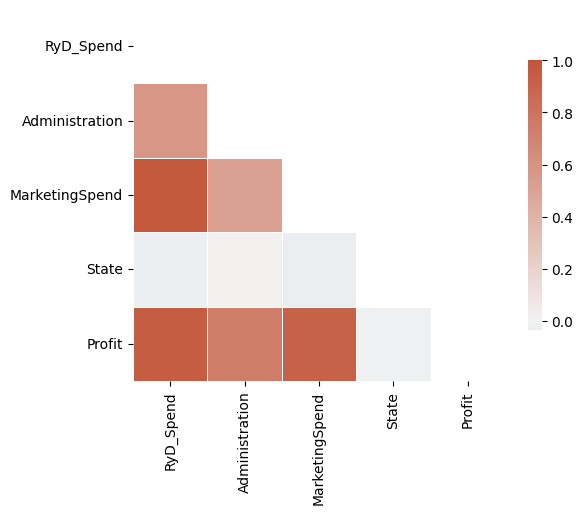

In [14]:
def grafico_correlacion(df, columnas):
    df_copy = df.copy()  # Hacer una copia del dataframe

    for columna in columnas:
        # Hacer un encoding de frecuencia para la variable categórica
        encoding = df_copy.groupby(columna).size()
        encoding = encoding / len(df_copy)
        df_copy[columna] = df_copy[columna].map(encoding)

    # Calcular la matriz de correlación
    corr = df_copy.corr()

    # Crear una máscara para el triángulo superior para no mostrar repetidos
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generar un mapa de colores divergentes personalizado
    fig, ax = plt.subplots(figsize=(6, 7))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Mostrar el gráfico
    plt.show()

grafico_correlacion(companies, ['State']) # state es la unica categorica aqui

Tal como lo habiamos identicado previamente, la variable estado no es de influencia para determinar el comportamiento de las variables. Aqui lo notamos por su baja correlacion.

Notamos rapidamente que Profit tiene correlaciones con gastos en marketing y RyD.

### Estandarización

Probaremos 3 metodos de estandarización de los datos. La idea es visualizar el comportamiento de cada modelo y elejir uno que pueda presentar ventaja ante los demas.

In [15]:
def estandarize(df):
    # escalado estandar entre las variables
    data = df.copy()
    numeric_cols = data.select_dtypes(include=[np.number]).columns # solo escalo las numericas
    scaler = StandardScaler()

    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler # retornan el scaler entrenado por si necesitaramos revertir

def normalize(df):
    # escalo en un rango entre 0 y 1
    data = df.copy()
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()

    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler

def robustize(df):
    # escalado robusto para reducir la influencia de outliers
    data = df.copy()
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()

    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler

Se crea una celda de codigo interactiva que permite seleccionar y graficar las variables con el metodo de estandarizacion elejido.

In [16]:
# Crear un diccionario de funciones de estandarización
standardize_dict = {
    'Estandar': estandarize,
    'MinMax': normalize,
    'Robust': robustize
}

def show_distributions(df, method):
    # boxplot del dataset
    df_standardized, _ = standardize_dict[method](df)
    plt.figure(figsize=(8, 4))
    sns.boxplot(df_standardized)
    plt.xticks(rotation=90)
    plt.show()

# Crear selector de método de estandarización
method_widget = widgets.Dropdown(
    options=[method for method in standardize_dict.keys()],
    description='Método:',
)

# Usar interact para crear la actualizar el gráfico en un cambio
interact(show_distributions, df=widgets.fixed(companies_encoded), method=method_widget)

interactive(children=(Dropdown(description='Método:', options=('Estandar', 'MinMax', 'Robust'), value='Estanda…

<function __main__.show_distributions(df, method)>

Elejiremos el escalado estandar. Esto se debe a que mantiene un rango de valores comunes a todas las variables. Si bien un MinMax scaler tambien lo hace, logra que las distribuciones de las variables entre si sea dispareja. Un robust scaler tiene un comportamiento similar al Standar, pero el tratamiento de valores atipicos no es necesario en contexto de modelos basados en arboles.

In [17]:
df_standar, standar_scaler = estandarize(companies_encoded)
df_standar.head(2) # muesrta de como quedarian los valores

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,1.799023,1.105197,2.682968,0.047231,1.696301
1,1.739869,2.253692,2.378316,1.161177,1.685343


----

## **Segundo ejercicio**

---

Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Error Absoluto Medio, Error Cuadrático Medio y Raíz del Error
Cuadrático Medio)

---

### Regresión de arboles de decisión

La siguiente celda tiene la intencion de ser interactiva. Lo que se genera es un menu de selecion para cada hiperparametro del modelo.

Podemos modificar individualmente cada hiperparametro en los widgets generados, y al apretar el boton 'Estimar Profit' se entrena un modelo de regresion basado en arboles de desicion con los parametros elejidos. Luego genera las metricas de validacion en los conjunto de test en un dataframe.

Debajo se genera un grafico de como se ve el arbol de desicion que se ha entrenado.

In [74]:
# Crear los widgets para los parámetros y define los rangos
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1, description='Max Depth:')
min_samples_split_widget = widgets.IntSlider(min=2, max=50, step=1, description='Min Split:')
min_samples_leaf_widget = widgets.IntSlider(min=1, max=50, step=1, description='Min Leaf:')
criterion_widget = widgets.Dropdown(options=['squared_error', 'friedman_mse', 'absolute_error'], description='Criterion:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Profit")

# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y pruebas (70/15/15)
    X_train, X_temp, y_train, y_temp = train_test_split(df_standar.drop('Profit', axis=1), df_standar['Profit'], test_size=0.3, random_state=42)
    X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Crear y entrenar el modelo con los parametros elejidos
    model = DecisionTreeRegressor(max_depth=max_depth_widget.value,
                                  min_samples_split=min_samples_split_widget.value,
                                  min_samples_leaf=min_samples_leaf_widget.value,
                                  criterion=criterion_widget.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores en conjunto de test 1
    predictions1 = model.predict(X_test1)
    mae1 = mean_absolute_error(y_test1, predictions1)
    mse1 = mean_squared_error(y_test1, predictions1)
    rmse1 = sqrt(mse1)
    r21 = r2_score(y_test1, predictions1)

    # Realizar las predicciones y calcular los errores en conjunto de test 2
    predictions2 = model.predict(X_test2)
    mae2 = mean_absolute_error(y_test2, predictions2)
    mse2 = mean_squared_error(y_test2, predictions2)
    rmse2 = sqrt(mse2)
    r22 = r2_score(y_test2, predictions2)

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Error Absoluto Medio': [mae1, mae2],
        'Error Cuadrático Medio': [mse1, mse2],
        'Raíz del Error Cuadrático Medio': [rmse1, rmse2],
        'R^2': [r21, r22]
    })

    # Definir la figura
    fig = plt.figure(figsize=(15,10))

    # Crear el gráfico del árbol
    plot_tree(model, filled=True)

    # Mostrar los resultados y el gráfico en el contenedor de salida
    with out:
        display(results) # dataframe de metricas
        plt.show() # arbol

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(max_depth_widget, min_samples_split_widget, min_samples_leaf_widget, criterion_widget, button, out)

# 3, 2, 3, squared_error es lo mejor que encontre

IntSlider(value=1, description='Max Depth:', max=20, min=1)

IntSlider(value=2, description='Min Split:', max=50, min=2)

IntSlider(value=1, description='Min Leaf:', max=50, min=1)

Dropdown(description='Criterion:', options=('squared_error', 'friedman_mse', 'absolute_error'), value='squared…

Button(description='Estimar Profit', style=ButtonStyle())

Output()

### Selección

Mediante pruebas en el entrenamiento interactivo del modelo de regresion, podemos comprobar que los parametros usados debajo, son los mas optimos encontrados a mano. Ya que las metricas de error y explicabilidad (R2) son mejores para los parametros establecidos en ambos conjuntos de validacion.

Por ello, como modelo final podemos crearlo con los parametros siguientes.

In [19]:
X = df_standar.drop('Profit', axis=1)
y = df_standar['Profit']

# solo usamos 10% de validcion ya que sabemos que rinde bien esta configuracion por informacion previa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# parametros definidos
model = DecisionTreeRegressor(max_depth=8, min_samples_split=2, min_samples_leaf=3, criterion='squared_error')

# entrenar y predeccir
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# metricas rmse y r2
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'r2: {r2}\nrmse: {rmse}')

r2: 0.9991241875766429
rmse: 0.030359816281965178


Las metricas obtenidas son muy buenas. Podemos conocer mas a detalle como el modelo realiza predicciones en el siguiente analisis de residuos.

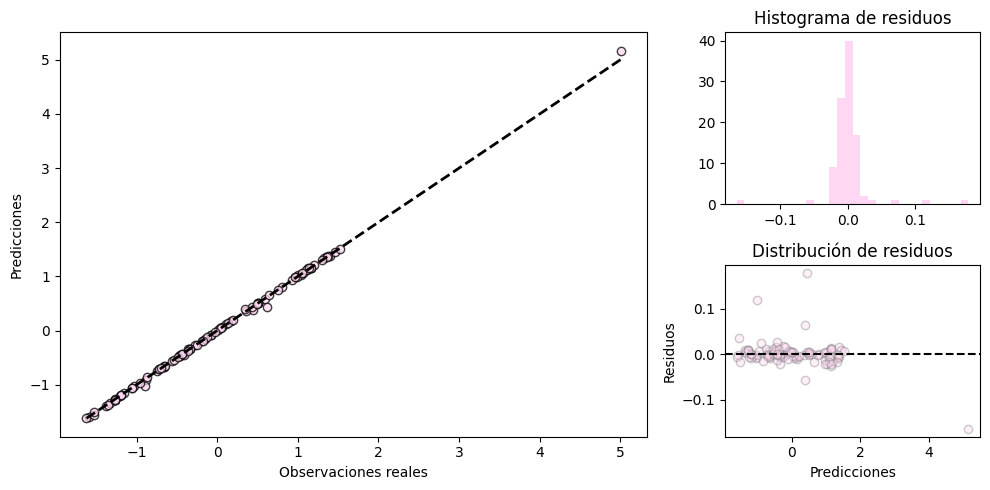

In [20]:
def evaluate_regression_model(color, obs, preds):
    # distribucion de los ejes
    fig = plt.figure(figsize=(10, 5))
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 3), (0, 2))
    ax2 = plt.subplot2grid((2, 3), (1, 2))

    # obtengo los residuos (error entre las prediciones y valores reales)
    residuos = obs - preds

    # ver como se ajustan los datos al modelo ideal
    ax0.scatter(obs, preds, color=color, alpha=0.75, edgecolor="black")
    ax0.plot([obs.min(), obs.max()], [obs.min(), obs.max()], 'k--', lw=2)
    ax0.set_xlabel("Observaciones reales")
    ax0.set_ylabel("Predicciones")

    # historigrama de frecuencias de residuos
    ax1.hist(residuos, bins=30, color=color)
    ax1.set_title(f"Histograma de residuos")

    # scatter de distribucion
    ax2.scatter(preds, residuos, color=color, alpha=0.4, edgecolors='gray')
    ax2.axhline(y=residuos.mean(), color='black', linestyle='--')
    ax2.set_xlabel("Predicciones")
    ax2.set_ylabel("Residuos")
    ax2.set_title(f"Distribución de residuos")

    plt.tight_layout()
    plt.show()

colors = ['#FFD7F2']
predicciones = [predictions]
evaluate_regression_model(colors[0], y_test, predicciones[0])

Notemos que las predicciones que hace nuestro modelo son casi los mismos valores reales. Es decir, por ejemplo, para una observacion de profit 0 (escalado), el modelo predice 0, o un valor muy cercano.

En el historigrana de residuos vemos una distribucion normal concentrados en 0. Esto significa que el modelo tiene errores muy chicos. Y junto con el scatter debajo de este historigrama, podemos conluir que el modelo no sobreestima ni subestima valores de forma sistematica.

Como conlusion, el modelo de regresion basado en arboles para este conjunto de datos y objetivo en particular es casi ideal para realizar estimaciones.

---

## **Tercer ejercicio**

---

Descargar el conjunto de datos, PokemonDB.csv2, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.)

---

### Información básica

Se pretende navegar atraves de la composición básica de este dataset. Damos a conocer su tamaño, tipos de datos, muestras de filas, metricas generales, y conocer la presencia de valores faltantes, y la cantidad de valores unicos de cada variable de forma gráfica.

In [21]:
cartas.shape

(1190, 8)

In [22]:
cartas.head()

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65


In [23]:
cartas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


Contamos con dos variables categoricas, y seis variables numericas discretas.

In [24]:
cartas.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,70.852941,80.957983,74.586555,72.756303,72.050420,69.695798
std,26.886443,32.119650,30.718212,32.658636,27.637522,30.204376
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,51.250000,56.000000,51.000000,50.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,70.000000,67.000000
75%,85.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


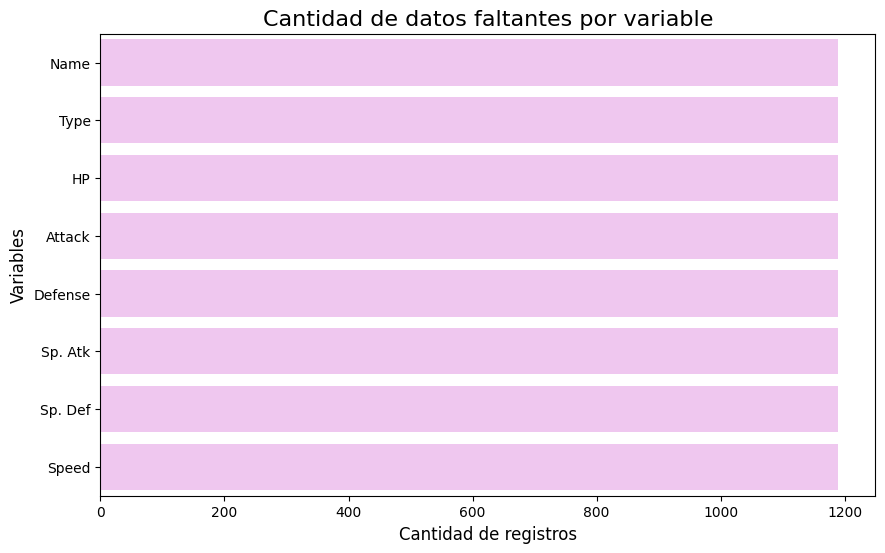

In [25]:
graficar_datos_faltantes(cartas)

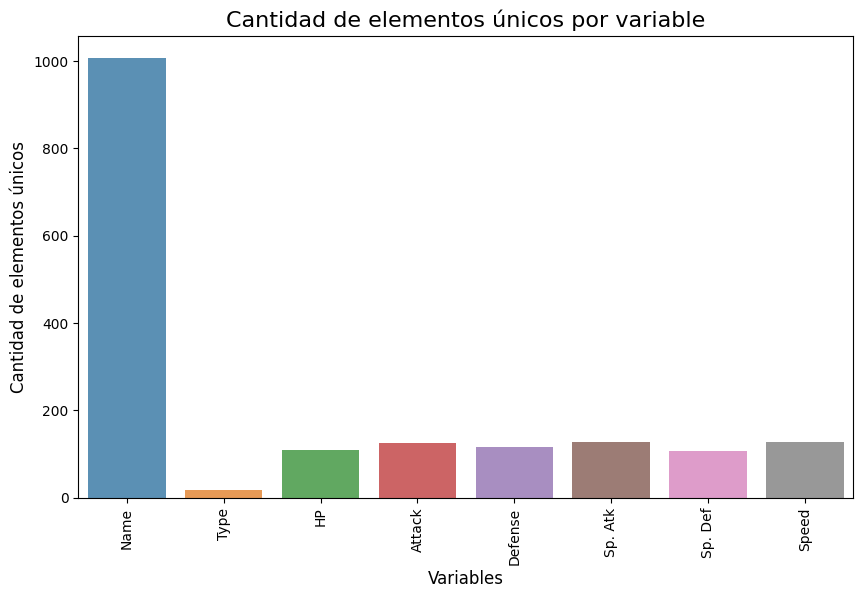

In [26]:
graficar_elementos_unicos(cartas)

No tenemos valores nulos en el dataset. La categoria Type tiene solo unas pocas clases. En cambio Name tiene casi tantas clases distintas como registros en el dataset. Esto suguiete que el nombre es un identificador de cada registro.

### Distribuciones por clase

Generamos un grafico interactivo que, tiene la intencion de mostrar las distribuciones de las variables numericas en base a las clases de Type.

In [27]:
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in cartas.columns if col not in ['Type', 'Name']], # solo usamos las numericas para la distribucion
    description='Explicativa:',
)

class_value_widget = widgets.Dropdown(
    options=['Todas'] + list(cartas['Type'].unique()), # damos la opcion de elejir todas o solo una clase
    description='Type:',
)

interact(create_plots, df=widgets.fixed(cartas), explanatory_var=explanatory_var_widget, class_var=widgets.fixed('Type'), class_value=class_value_widget)

interactive(children=(Dropdown(description='Explicativa:', options=('HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp.…

<function __main__.create_plots(df, explanatory_var, class_var, class_value)>

En esta caso podemos notar que la varibale Type no resulta diferianble para las otras variables.

Es decir, notamos las distribuciones de cada clase de type de forma muy similar entre si. No hay clases que tengan distribuciones significativamente diferente a las demas clases.

Esto suguiere, que para el objetivo de predecir la clase de Type para una serie de valores dados, sera dificil encontrar una relacion directa.

### Distribución por variable

Podemos representar la misma información que antes pero esta vez considerando todo el rango de valores para visualizar de forma global el comportamiento de las mismas.

In [28]:
# Crear selector de variable numericas
variable_widget = widgets.Dropdown(
    options=[col for col in cartas.columns if col not in ['Type', 'Name']],
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, df=widgets.fixed(cartas), variable=variable_widget)

interactive(children=(Dropdown(description='Variable:', options=('HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. De…

<function __main__.create_dist(df, variable)>

En su mayoria, notamos asimetrias en las distribuciones hacia la derecha. Esto indica que todas las variables tienden a manejar valores normalmente mas bajos, o dicho de otra forma, los valores atipicos encontrados en los atributos de los personajes son generalemte mayores a los demas. Por ejemplo, puede ocurrir que un personaje tenga una velocidad mucho mayor que todos los demas. Pero no ocurre que alguno tenga una velocidad mucho mas baja que la de los demas.

### Duplicados

Se sospecha que hay valores duplicados en las filas debido a que cada registro representa los atributos de cada personaje de las cartas.

Pero tenemos mas registros que nombres de personajes, por lo tanto debe haber nombres repetidos.

In [29]:
# Crear una máscara booleana para las filas donde 'Name' se repite
mask = cartas.duplicated('Name', keep=False)

# Aplicar la máscara al dataframe
cartas[mask]

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
6,Charizard,Fire,78,84,78,109,85,100
7,Charizard,Fire,78,130,111,130,85,100
8,Charizard,Fire,78,104,78,159,115,100
...,...,...,...,...,...,...,...,...
1143,Palafin,Water,100,160,97,106,87,100
1161,Dudunsparce,Normal,125,100,80,85,75,55
1162,Dudunsparce,Normal,125,100,80,85,75,55
1179,Gimmighoul,Ghost,45,30,70,75,70,10


Notemos que hay nombres de personajes repetidos, pero con atributos distintos. A estos vamos a mantenerlos debido a que podria ocurrir que haya personajes con el mismo nombre o que se hayan considerado sus atributos en considiones diferentes.

Pero tambien tenemos registros que directamente son repetidos en todos sus atributos. A estos los eliminamos del dataframe debido a que no tiene relevancia tener dos filas iguales.

In [30]:
# Eliminar las filas duplicadas
cartas = cartas.drop_duplicates()
cartas[mask]

<ipython-input-30-e944975ebdef>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cartas[mask]


,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
6,Charizard,Fire,78,84,78,109,85,100
7,Charizard,Fire,78,130,111,130,85,100
8,Charizard,Fire,78,104,78,159,115,100
...,...,...,...,...,...,...,...,...
1142,Palafin,Water,100,70,72,53,62,100
1143,Palafin,Water,100,160,97,106,87,100
1161,Dudunsparce,Normal,125,100,80,85,75,55
1179,Gimmighoul,Ghost,45,30,70,75,70,10


Notar que de las 331 filas que repiten los nombres, solo 29 eran totalmente duplicados.

### Valores atípicos

Habiamos notado que todas las variables tienen valores atipicos. Si bien para el objetivo de trabajarlos dentro de un modelo de clasificacion basado en arboles no es necesario preocuparse por ellos. Podemos tratar un enfoque de escalar el rango de forma logaritmica para probar el rendimiento.

<Axes: >

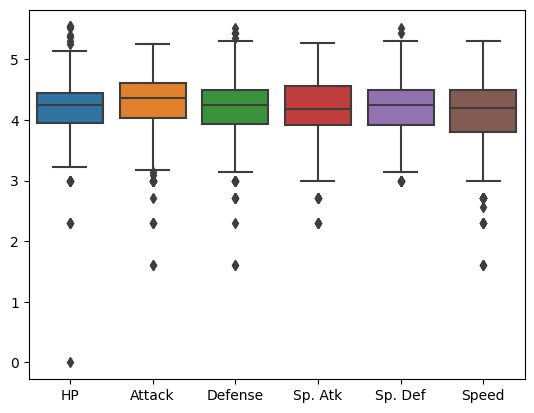

In [31]:
cartas_log = cartas.copy()
for col in cartas_log.select_dtypes(include=[np.number]).columns:
    cartas_log[col] = np.log(cartas_log[col])

sns.boxplot(cartas_log)

### Correlación

Utilizaremos la misma funcion para generar una matriz de correlacion que incluye las variables categoricas de forma codificadas con el fin de analizar relaciones directas entre las variables.

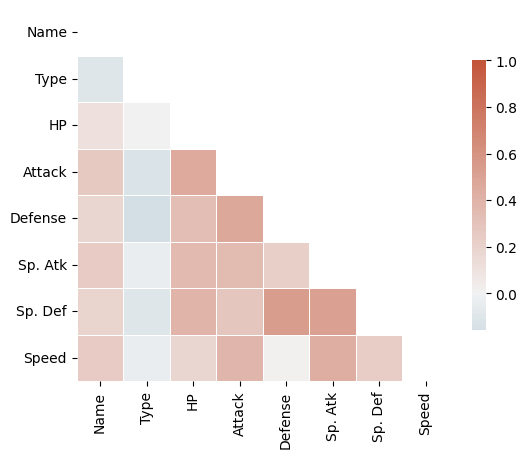

In [32]:
grafico_correlacion(cartas, ['Type', 'Name'])

Notamos rapidamente que para este dataset no hay relaciones lineales fuertes entre las variables. En especial la variable Type, tiene correlaciones casi nulas. Esto suma a la hipotesis de que Type es muy poco explicativa ante las demas variables.

Esto significa que conociendo valores como la fuerza, resistencia o velocidad de un personaje, es dificil determinar a que Type pertenece el mismo debido a que podria ser cualquiera, debido a que las distribuciones entre cada clase es muy similar.

### Codificación

Como a los arboles no les afecta una codificacion de clases como a los modelos de regresion, podemos codificar con LabelEncoder de forma ordinal ya que no interpreta a una clase como mayor que otra, si no que las considera en su naturaleza nominal.

In [33]:
cartas_encoded = cartas.copy()

# Crear el LabelEncoder
le = LabelEncoder()

# Aplicar el LabelEncoder a las columnas deseadas
cartas_encoded['Type'] = le.fit_transform(cartas_encoded['Type'])
cartas_encoded['Name'] = le.fit_transform(cartas_encoded['Name'])

---

### Balances

Para problemas de casificacion es importante considerar si tenemos suficientes datos de cada clase para realizar un entrenamiento 'justo' con la misma cantidad de datos para cada clase. Esto para evitar sesgos en clases que minoria de registros.

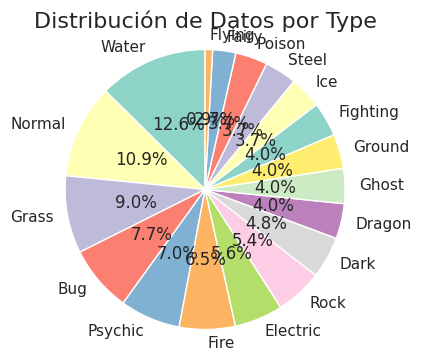

In [34]:
def graficar_proporcion_datos(df, column):
    value_counts = df[column].value_counts() # cantidad de calores de cada clase

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.5, colors=sns.color_palette('Set3')) # visualizacion en pie chart

    plt.title(f'Distribución de Datos por {column}', fontsize=16)
    plt.axis('equal')

    plt.show()

graficar_proporcion_datos(cartas, 'Type')

Las clases de la variabe type estan desbalancedas. Por lo que metricas de valicion para modelos de clasificacion deberain ser interpretadas cuidadosamente.

Podemos generar una copia de este dataset que solucione este inconveniente utilizando el enfoque de oversampling que genera datos para las clases minoritarias pero 'a conciencia' de generar datos cercanos para que pertenezcan al mismo grupo utilizando tecnicas de vecinos cercanos.

In [35]:
def over_classes(df, target_var):
    # Separar las variables explicativas y la variable objetivo
    X = df.drop(target_var, axis=1)
    y = df[target_var]

    categorical_features = X.columns.isin(['Type', 'Name'])

    # Crear el objeto SMOTENC
    smote = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    print(f'shape balanceado: {X_res.shape[0]}')

    # Devolver el DataFrame balanceado
    return pd.concat([X_res, y_res], axis=1)

# Llamada a la función
cartas_oversampling = over_classes(cartas_encoded, 'Type')
print(f'shape original: {cartas_encoded.shape[0]}')

shape balanceado: 2628
shape original: 1161


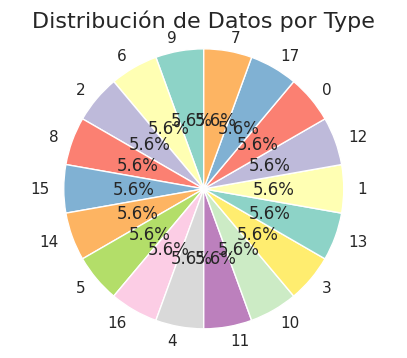

In [36]:
graficar_proporcion_datos(cartas_oversampling, 'Type')

De esta forma obtenemos un conjunto de datos mas extenso que obtiene un balance en la proporcion de muestras de cada clase, pero con la precaucion de que se han generado datos sinteticos para lograr este efecto.

## **Cuarto ejercicio**

---

Realizar la estimación del atributo Type utilizando árboles de decisión (Clasificación)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Clasificación con arboles de decisión

La siguiente celda de codigo genera un menu de selecion de los hiperparametros de forma interactiva. Esto permite modificar los pararametros que recibe el modelo para realizar el entrenamiento y ganar intuicion de como cada parametro individualmente afecta el rendimiento de las predicciones.

In [37]:
# Crear los widgets para los parámetros con rangos predefinidos
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1, description='Max Depth:')
min_samples_split_widget = widgets.IntSlider(min=2, max=50, step=1, description='Min Split:')
min_samples_leaf_widget = widgets.IntSlider(min=1, max=50, step=1, description='Min Leaf:')
criterion_widget = widgets.Dropdown(options=['gini', 'entropy'], description='Criterion:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Type")

# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(cartas_oversampling.drop('Type', axis=1), cartas_oversampling['Type'], test_size=0.3, random_state=42)
    # X_train, X_temp, y_train, y_temp = train_test_split(cartas.drop('Type', axis=1), cartas['Type'], test_size=0.3, random_state=42) # aca intente con el dataset no oversamplado y da peores metricas
    X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Crear y entrenar el modelo
    model = DecisionTreeClassifier(max_depth=max_depth_widget.value,
                                   min_samples_split=min_samples_split_widget.value,
                                   min_samples_leaf=min_samples_leaf_widget.value,
                                   criterion=criterion_widget.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores en ambos conjuntos de test
    predictions1 = model.predict(X_test1)
    probabilities1 = model.predict_proba(X_test1)
    precision1 = precision_score(y_test1, predictions1, average='macro', zero_division=0)
    recall1 = recall_score(y_test1, predictions1, average='macro')
    accuracy1 = accuracy_score(y_test1, predictions1)
    auc1 = roc_auc_score(y_test1, probabilities1, multi_class='ovr')

    predictions2 = model.predict(X_test2)
    probabilities2 = model.predict_proba(X_test2)
    precision2 = precision_score(y_test2, predictions2, average='macro', zero_division=0)
    recall2 = recall_score(y_test2, predictions2, average='macro')
    accuracy2 = accuracy_score(y_test2, predictions2)
    auc2 = roc_auc_score(y_test2, probabilities2, multi_class='ovr')

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Precisión': [precision1, precision2],
        'Exhaustividad': [recall1, recall2],
        'Exactitud': [accuracy1, accuracy2],
        'AUC': [auc1, auc2]
    })

    # Mostrar los resultados en el contenedor de salida
    with out:
        display(results)
        plot_tree(model, filled=True) # mustra el arbol de decision

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(max_depth_widget, min_samples_split_widget, min_samples_leaf_widget, criterion_widget, button, out)

# 10, 8, 8, gini es lo mejor que encontre
#36, 75

IntSlider(value=1, description='Max Depth:', max=20, min=1)

IntSlider(value=2, description='Min Split:', max=50, min=2)

IntSlider(value=1, description='Min Leaf:', max=50, min=1)

Dropdown(description='Criterion:', options=('gini', 'entropy'), value='gini')

Button(description='Estimar Type', style=ButtonStyle())

Output()

Notamos que las metricas de validacion son mmuy bajas para ambos conjuntos. Esto confirma la hipotesis de que las variables del dataset no son lo suficientemente explicativas para estimar el atributo Type debido a las similaridades de cada distribucion de cada clase y sus bajos niveles de correlacion.

### Seleción

Si fuera requisito el poder clasificar la clase type de un personaje con estas condiciones dadas usando un modelo basado en arboles, se elije un modelo con los siguientes paramatros que fueron los mas optimos (o los menos bajos) encontrados manualmente.

In [38]:
# seleccion y separacion de variables
X = cartas_oversampling.drop('Type', axis=1)
y = cartas_oversampling['Type']

# solo usamos 10% de validacion por que ya probamos que el modelo bien con estos parametros
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = DecisionTreeClassifier(max_depth=18, min_samples_split=42, min_samples_leaf=6, criterion='gini')
model.fit(X_train, y_train)

# obtenemos predicciones y probabilidades las clases
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

# obtener el accuracy y el are bajo la curva roc de este modelo
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, probabilities, multi_class='ovr')
print(f'accuracy: {accuracy}\nauc: {auc}')

accuracy: 0.3193916349809886
auc: 0.7674844407828403


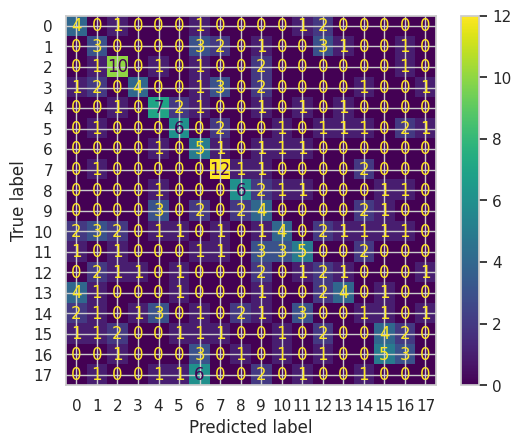

In [39]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Como bien podemos ver, solo tiene un accuracy del 0.31. Es decir solo en el 32% de las predicciones fueron correctamentes clasificadas por el modelo. Notar por ejemplo, que algo particular tiene la clase 2 y 7 en esta matrix de confusion que tienen mayores aciertos a la hora de clasificar que las demas clases. Es posible que se deba a las distribuciones de las clases que se diferenciaban levemente de las demas.

## **Quinto ejercicio**

---

Realizar la estimación del atributo Type utilizando Bayes Ingenuo. Aquí deberá
considerar un criterio de división de los atributos para discretizarlos. Mostrar los
resultados sobre dos conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Multinomial

Para este contexto de variables numericas y clases planteamos dos alternativas para realizar esimaciones de clases de una variable utilizando algoritmos de bayes ingenuos.

Podemos codificar discretizar nuestras variables como clases. De esta forma tratamos el algoritmo de bayes de forma que trabajara con probabilidades condicionales de clases para hacer estimaciones. Por lo que usaremos un modelo multinomial.

Bayes Ingenuo asume que las distribuciones de las clases son normales y balanceadas. Por ende utilizaremos el dataset balanceado de cartas.

In [73]:
# Crear los widgets para los parámetros
n_bins_w = widgets.IntSlider(min=2, max=50, step=1, description='Nro. bins:')
encode_w = widgets.Dropdown(options=['onehot', 'onehot-dense', 'ordinal'], description='Encode:')
strategy_w = widgets.Dropdown(options=['uniform', 'quantile', 'kmeans'], description='Strategy:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Type")

# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(cartas_oversampling.drop('Type', axis=1), cartas_oversampling['Type'], test_size=0.3, random_state=42)
    X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # entrena un discretizador a corde a las variables
    discretizer = KBinsDiscretizer(n_bins=n_bins_w.value, encode=encode_w.value, strategy=strategy_w.value, random_state=42)
    X_train = discretizer.fit_transform(X_train)
    X_test1 = discretizer.transform(X_test1)
    X_test2 = discretizer.transform(X_test2)

    # Creamos y entrenamos el modelo
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores
    predictions1 = model.predict(X_test1)
    precision1 = precision_score(y_test1, predictions1, average='macro', zero_division=0)
    recall1 = recall_score(y_test1, predictions1, average='macro')
    accuracy1 = accuracy_score(y_test1, predictions1)

    predictions2 = model.predict(X_test2)
    precision2 = precision_score(y_test2, predictions2, average='macro', zero_division=0)
    recall2 = recall_score(y_test2, predictions2, average='macro')
    accuracy2 = accuracy_score(y_test2, predictions2)

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Precisión': [precision1, precision2],
        'Exhaustividad': [recall1, recall2],
        'Exactitud': [accuracy1, accuracy2]
    })

    # Definir la figura y los ejes del gráfico
    fig, ax = plt.subplots()

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test1, predictions1)

    # Crear el gráfico de la matriz de confusión
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)

    # Mostrar los resultados y el gráfico en el contenedor de salida
    with out:
        display(results)
        plt.show()

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(n_bins_w, encode_w, strategy_w, button, out)

# 25, onehot, kmeans es lo mejor que encontre


IntSlider(value=2, description='Nro. bins:', max=50, min=2)

Dropdown(description='Encode:', options=('onehot', 'onehot-dense', 'ordinal'), value='onehot')

Dropdown(description='Strategy:', options=('uniform', 'quantile', 'kmeans'), value='uniform')

Button(description='Estimar Type', style=ButtonStyle())

Output()

Esta celda genera un control interactivo para adaptar los parametros del discretizador, es decir la forma de generar clases o rangos de valores para las variables numericas usando diferentes estrategias.

Por ejemplo, discretizando los rangos numericos en 25 clases y usando una estrategia de kmeas para separar las clases, se llega a un 33% de casos acertados en la clasificacion.

### Gaussiano

Otra enfoque para trabajar con bayes ingenuos es no discretizar los rangos numericos, sino hacer que el algorimo considere las distribuciones de probabilidad de las clases para calcular las probalidades condicionales. Para ello se un modelo diferente de la libreria. Notar que el mismo no requiere customizar parametros.

In [41]:
# Supongamos que 'cartas_encoded' es tu DataFrame y 'Type' es la columna que quieres predecir
X = cartas_encoded.drop(['Type'], axis=1)  # usamos todas las columnas excepto 'Type' y 'Name'
y = cartas_encoded['Type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(cartas_oversampling.drop('Type', axis=1), cartas_oversampling['Type'], test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Creamos y entrenamos el modelo
model = GaussianNB()
model.fit(X_train, y_train)

# Realizar las predicciones y calcular los errores
predictions1 = model.predict(X_test1)
probabilities1 = model.predict_proba(X_test1)
precision1 = precision_score(y_test1, predictions1, average='macro', zero_division=0)
recall1 = recall_score(y_test1, predictions1, average='macro')
accuracy1 = accuracy_score(y_test1, predictions1)
auc1 = roc_auc_score(y_test1, probabilities1, multi_class='ovr')

predictions2 = model.predict(X_test2)
probabilities2 = model.predict_proba(X_test2)
precision2 = precision_score(y_test2, predictions2, average='macro', zero_division=0)
recall2 = recall_score(y_test2, predictions2, average='macro')
accuracy2 = accuracy_score(y_test2, predictions2)
auc2 = roc_auc_score(y_test2, probabilities2, multi_class='ovr')

results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Precisión': [precision1, precision2],
        'Exhaustividad': [recall1, recall2],
        'Exactitud': [accuracy1, accuracy2],
        'AUC': [auc1, auc2]
    })

display(results)

,Conjunto de prueba,Precisión,Exhaustividad,Exactitud,AUC
0,Prueba 1,0.163169,0.191396,0.185279,0.704893
1,Prueba 2,0.140566,0.175584,0.174684,0.693502


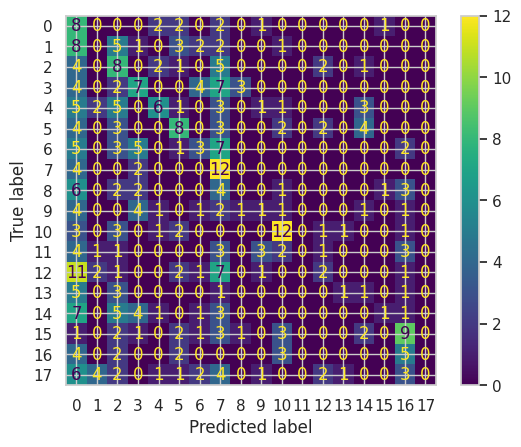

In [42]:
cm = confusion_matrix(y_test1, predictions1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Notamos metricas de clasificaion muy bajas para este enfoque. La matrix de confusion indica que solo tiene buen porcentaje de acercion para las clases 7 y 10. Que podemos conocer que personajes de esta forma:

In [43]:
le.inverse_transform([7, 10])

array(['Aipom', 'Alomomola'], dtype=object)

## **Sexto ejercicio**

---

Realizar la estimación del atributo Type utilizando k-NN analizando los parámetros
cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre un conjunto de
test (Precisión, Exhaustividad y Exactitud)

---

### K nearest neightbour

El algoritmo de los k vecinos más cercanos (k-NN), también puede ser sensible a cómo se codifican las variables categóricas. Aunque k-NN no asume una relación ordinal entre las categorías como lo hace la regresión lineal, todavía utiliza la distancia entre los puntos de datos para hacer sus predicciones. Por lo que al codificar las categorías con LabelEncoder, las distancias pueden no representar adecuadamente las similitudes entre las categorías.

Para ello utilizaremos el enfoque de codificacion frecuencial, que asigna un valor continuo a cada clase que representa su frecuencia de aparacion en el dataset.


K-NN tiene hiperparametros que se pueden ajustar para mejorar la estimacion de las clases. En este caso se genera un menu interactivo para adapar los parametros a mano y conseguir una buena combinacion de las mismas.

In [64]:
# Crear los widgets para los parámetros
knn_w = widgets.IntSlider(min=1, max=30, step=1, description='K:')
metric_w = widgets.Dropdown(options=['euclidean', 'manhattan', 'minkowski'], description='Metric:')
p_w = widgets.IntSlider(min=1, max=2, step=1, description='P:')
weights_w = widgets.Dropdown(options=['uniform', 'distance'], description='Weights:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Type")

# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # se transforman las categorias en forma frecuencial
    cartas_norm, _ = normalize(cartas) # normalizo los valores
    cartas_encoded = encode_frequency(cartas_norm, ['Name'])

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(cartas_encoded.drop('Type', axis=1), cartas_encoded['Type'], test_size=0.2, random_state=42)

    # Creamos y entrenamos el modelo
    model = KNeighborsClassifier(n_neighbors=knn_w.value, metric=metric_w.value, p=p_w.value, weights=weights_w.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)

    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    recall = recall_score(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities, multi_class='ovr')

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Precisión': [precision],
        'Exhaustividad': [recall],
        'Exactitud': [accuracy],
        'AUC': [auc]
    })

    pca = PCA(n_components=2)
    y_test_pca = pca.fit_transform(X_test)

    le = LabelEncoder()
    preds = le.fit_transform(predictions)

    plt.scatter(y_test_pca[:, 0], y_test_pca[:, 1], c=preds, cmap='rainbow')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('K-NN en y_test redicido por PCA')

    # Mostrar los resultados en el contenedor de salida
    with out:
        display(results)
        plt.show()

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(knn_w, metric_w, p_w, weights_w, button, out)

# 14, minkowski, 2, distance es lo mejor que encontre


IntSlider(value=1, description='K:', max=30, min=1)

Dropdown(description='Metric:', options=('euclidean', 'manhattan', 'minkowski'), value='euclidean')

IntSlider(value=1, description='P:', max=2, min=1)

Dropdown(description='Weights:', options=('uniform', 'distance'), value='uniform')

Button(description='Estimar Type', style=ButtonStyle())

Output()

Podemos notar que las metricas y el grafico no resultan alentadores para usar este modelo para estimar el tipo de pokemon debido a los bajos niveles de acertividad de las clases.

En el grafico, no podemos notar agrupaciones claras de las clases segun las prediciones.

### Selecion automatica

En lugar de probar manualmente la selecion de los parametros que mejores resultados otorgan para las metricas del modelo, podemos usar una utilidad que permite automaticamente selecionar el conjunto de parametros que optimizan las metricas.

Para ello se debe establecer un rango predefinido de los parametros para navegar. Y mediante un busqueda de grilla que hace entranamientos y validaciones iteravas, selecciona uno.

In [65]:
cartas_norm, _ = normalize(cartas)
cartas_encoded = encode_frequency(cartas_norm, ['Name'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(cartas_encoded.drop('Type', axis=1), cartas_encoded['Type'], test_size=0.2, random_state=42)

params = {
    'n_neighbors': range(1, 20, 1), # probar entre 1 y 20 vecinos cernanos
    'p': [1,2], # probar metricas eucledianas o de manhatan
    'weights': ['uniform', 'distance'] # forma de obtener los pesos
}

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, n_jobs=-1, verbose=1, return_train_score=True)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


Podemos notar que selecciona como mejor combinacion de parametros valores muy cernanos a los encontrados manualmente.

Notamos que diferencia no es significativa en las metricas de validacion entre 14 y 15 vecinos cercanos. Podemos notar el por que en el siguiente grafico.

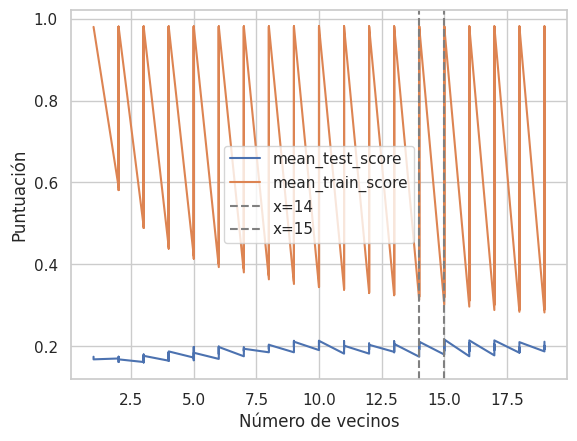

In [68]:
# Convertir los resultados en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Graficar las curvas de validación
for metric in ['mean_test_score', 'mean_train_score']:
    plt.plot(results['param_n_neighbors'], results[metric], label=metric)

# Agregar una línea vertical de las selecciones
plt.axvline(x=14, color='gray', linestyle='--', label='x=14')
plt.axvline(x=15, color='gray', linestyle='--', label='x=15')

plt.legend()
plt.xlabel('Número de vecinos')
plt.ylabel('Puntuación')
plt.show()

Notamos que la metrica en entrenamiento es muy cercana para 14 y 15 vecinos. Pero que con 14 vecinos la metrica en validacion es levemente menor.

### Seleccion

Creamos un modelo final con las metricas selecionadas listo para estimaciones de tipos de pokemon.

,Precisión,Exhaustividad,Exactitud
0,0.245792,0.195807,0.23176


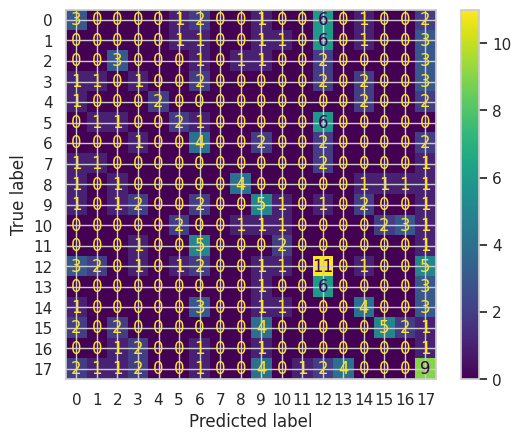

In [71]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(cartas_encoded.drop('Type', axis=1), cartas_encoded['Type'], test_size=0.2, random_state=42)

model = KNeighborsClassifier(n_neighbors=14, weights='distance', metric='minkowski', p=1)
model.fit(X_train, y_train)

# Realizar las predicciones y calcular los errores
predictions = model.predict(X_test)
precision = precision_score(y_test, predictions, average='macro', zero_division=0)
recall = recall_score(y_test, predictions, average='macro')
accuracy = accuracy_score(y_test, predictions)

# Crear un DataFrame para mostrar los resultados
results = pd.DataFrame({
    'Precisión': [precision],
    'Exhaustividad': [recall],
    'Exactitud': [accuracy]
})

display(results)
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Notamos particularmente que el tipo 12 (codificado) tiene muchas acerciones en la matriz de confucion que las demas clases. Esto puede deberse a que las distribuciones de las variables para esta clase sea algo diferente a las distribuciones de las otras clases.

# ***Conclusiones***

Se han trabajado dos conjuntos de datos diferentes, con objetivos diferentes.

Para el primero el objetivo fue estimar una variable continua usando una regresion basada en arboles. Los resultados fueron muy positivos y se han conseguido metricas de validacion de predicciones muy buenas con un modelo relativamente sencillo.

Para el segundo conjunto de datos, el objetivo fue de estimar clases, es decir, realizar clasificaciones de tipos de personajes. Se han probado 3 enfoques de modelos diferentes y cambiado los hiperparametros de cada uno. En los tres modelos de clasificacion las metricas de validacion sobre las predicciones resultaron insatisfactorias debido a los altas probabilidades de que se equivoquen al estimar una clase en base a otros atributos.

Aun asi se han probado tres enfoques de clasificacion diferentes donde algunos demostraron un mejor desempeño, aunque no significativo para ser elejido como modelo preferido para esta tarea.

Para lograr estimaciones de las clases con mayor precision es posible que se requieran modelos mas sotisficados o un dataset que aporte mas informacion, ya sea con mas variables explicativas o mas cantidad de registros para 'enriquecer' el entrenamiento de los modelos de clasificacion.